In [1]:
import os,glob
import torch
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import librosa
import soundfile as sf
from matplotlib import cm

In [1]:
root_sample = 'sample/'

# Funcs

In [3]:
def spectrogram(x) : 
    eps = 1e-13

    # dB scale
    tmp = np.sqrt(x[:,:,0]**2 + x[:,:,0]**2)
    tmp = np.clip(tmp,a_min=eps,a_max=None)
    tmp = 10*np.log10(tmp)
    tmp = tmp[::-1,:]

    im = plt.imshow(tmp, cmap=cm.jet, aspect='auto')
    plt.colorbar(im)
    plt.clim(-80,20)
    plt.show()

## Data Loading

In [4]:
pt_clean  = torch.load(root_sample + 'clean.pt')
pt_estim  = torch.load(root_sample + 'estim.pt')
pt_estim2  = torch.load(root_sample + 'estim2.pt')
pt_noisy  = torch.load(root_sample + 'noisy.pt')

np_clean = pt_clean.detach().numpy()
np_estim = pt_estim.detach().numpy()
np_estim2 = pt_estim2.detach().numpy()
np_noisy = pt_noisy.detach().numpy()

wav_output,_ = librosa.load(root_sample + 't22.wav',sr=16000)

## Plot

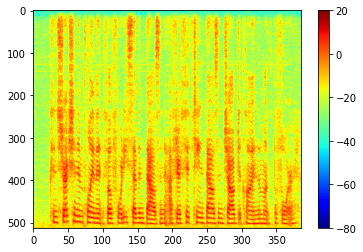

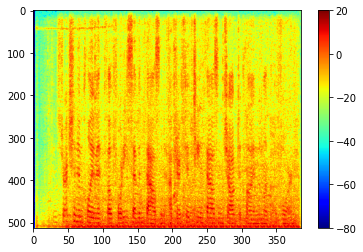

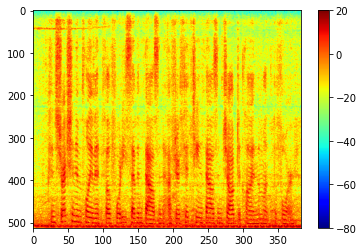

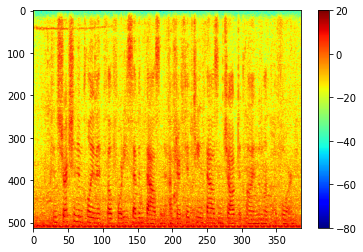

NameError: name 'np_output' is not defined

In [5]:
spectrogram(np_clean)
spectrogram(np_estim)
spectrogram(np_estim2)
spectrogram(np_noisy)
spectrogram(np_output)

## Back to Wav

In [6]:
cplx_clean = np_clean[:,:,0] + np_clean[:,:,1]*1j
cplx_estim = np_estim[:,:,0] + np_estim[:,:,1]*1j
cplx_estim2 = np_estim2[:,:,0] + np_estim2[:,:,1]*1j
cplx_noisy = np_noisy[:,:,0] + np_noisy[:,:,1]*1j
wav_clean = librosa.istft(cplx_clean)
wav_estim = librosa.istft(cplx_estim)
wav_estim2 = librosa.istft(cplx_estim2)
wav_noisy = librosa.istft(cplx_noisy)

#sf.write('re_clean.wav',wav_clean,16000)
#sf.write('re_estim.wav',wav_estim,16000)
#sf.write('re_noisy.wav',wav_noisy,16000)

## Out to pt

In [7]:
wav_output,_ = librosa.load(root_sample+'t22.wav',sr=16000)
np_output = librosa.stft(wav_output,window='hann', n_fft=1024, hop_length=256 , win_length=None ,center=True)
np_output = np.stack((np_output.real,np_output.imag),-1)

wav_output2,_ = librosa.load(root_sample+'t28.wav',sr=16000)
np_output2 = librosa.stft(wav_output2,window='hann', n_fft=1024, hop_length=256 , win_length=None ,center=True)
np_output2 = np.stack((np_output2.real,np_output2.imag),-1)

## Loss

In [8]:
# wav domain
def SISDR(output,target):
    Rss= np.dot(target, target)
            
    e_target= (np.dot( target, output) / Rss) * target
    e_res= e_target - output

    Sss= (e_target**2).sum()
    Snn= (e_res**2).sum()

    # SDR on dB scale
    #SISDR= 10 * torch.log10(Sss/Snn)
    return Sss/Snn

# wav domain
def SDR(output,target):
    xy = np.diag(output @ np.transpose(target))
    yy = np.diag(target @ np.transpose(target))
    xx = np.diag(output @ np.transpose(output))

    SDR = xy**2/ (yy*xx - xy**2 )
    return np.mean(SDR)    

MSE = torch.nn.MSELoss() 
L1  = MSE = torch.nn.L1Loss() 

def t1(output,target,alpha = 0.7,is_wav=False):
    
    if is_wav : 
        s_abs     = target.abs()
        s_hat_abs = output.abs()
    else : 
        s_abs = torch.sqrt(target[:,:,:,0]**2 + target[:,:,:,1]**2)
        s_hat_abs = torch.sqrt(output[:,:,:,0]**2 + output[:,:,:,1]**2)
    d =  s_abs + s_hat_abs
    return torch.mean(alpha *(d + d.abs())/2 + (1-alpha) * (d-d.abs())/2)

mel_basis = librosa.filters.mel(sr=16000, n_fft=1024,n_mels=40)
mel_basis = torch.from_numpy(mel_basis)

def t2(output,target,alpha=0.7):
    s_abs = torch.sqrt(target[:,:,:,0]**2 + target[:,:,:,1]**2)
    s_hat_abs = torch.sqrt(output[:,:,:,0]**2 + output[:,:,:,1]**2)
    
    s = torch.matmul(mel_basis,s_abs)
    s_hat = torch.matmul(mel_basis,s_hat_abs)
    d = s - s_hat
    return torch.mean(alpha *(d + d.abs())/2 + (1-alpha) * (d-d.abs())/2)
    

# Get Loss  
## Wav domain
+ wav_clean
+ wav_estim
+ wav_noisy
+ wav_output  

## STFT domain
+ np_clean
+ np_estim
+ np_noisy
+ np_output

In [9]:
print('wav_clean : '+ str(np.shape(wav_clean)))
print('wav_estim : '+ str(np.shape(wav_estim)))
print('wav_estim2 : '+ str(np.shape(wav_estim2)))
print('wav_noisy : '+ str(np.shape(wav_noisy)))
print('wav_output : '+ str(np.shape(wav_output)))
print('np_clean : '+ str(np.shape(np_clean)))
print('np_estim : '+ str(np.shape(np_estim)))
print('np_estim2 : '+ str(np.shape(np_estim2)))
print('np_noisy : '+ str(np.shape(np_noisy)))
print('np_output : '+ str(np.shape(np_output)))
print('np_output2 : '+ str(np.shape(np_output2)))

wav_clean : (98560,)
wav_estim : (98560,)
wav_estim2 : (97792,)
wav_noisy : (98560,)
wav_output : (98304,)
np_clean : (513, 386, 2)
np_estim : (513, 386, 2)
np_estim2 : (513, 383, 2)
np_noisy : (513, 386, 2)
np_output : (513, 385, 2)
np_output2 : (513, 385, 2)


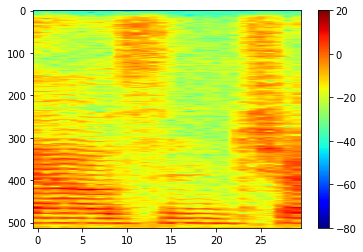

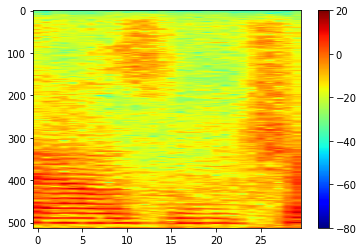

ValueError: operands could not be broadcast together with shapes (513,384,2) (513,382,2) 

In [194]:
s = 250
e = 280

spectrogram(np_clean[:,s+2:e+2,:])

# np_output is 4 frame faster
spectrogram(np_output[:,s-3:e-3,:])
#print(np.sum(np.abs(np_clean[:,5:,:]) - np.abs(np_output[:,:-4,:])))
for i in range(10):
    print(np.sum(np.abs(np.abs(np_clean[:,i:-2,:]) - np.abs(np_output[:,:-i-1,:]))))

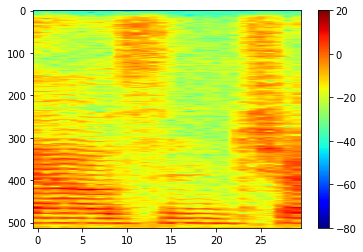

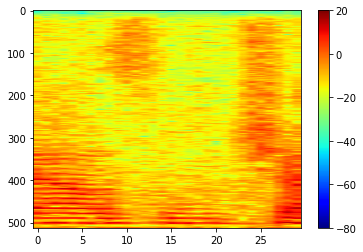

In [213]:
s = 250
e = 280

spectrogram(np_clean[:,s+2:e+2,:])
spectrogram(np_output2[:,s-2:e-2,:])

## Sample

In [14]:
s = 50
e = 350
sample_clean  = np_clean[:,s+2:e+2,:]
sample_estim  = np_estim[:,s+2:e+2,:]
sample_estim2  = np_estim2[:,s-1:e-1,:]
sample_output = np_output[:,s-3:e-3,:]
sample_output2 = np_output[:,s-2:e-2,:]

sample_clean = torch.from_numpy(sample_clean)
sample_estim = torch.from_numpy(sample_estim)
sample_estim2 = torch.from_numpy(sample_estim2)
sample_output = torch.from_numpy(sample_output)
sample_output2 = torch.from_numpy(sample_output2)

sample_clean = torch.stack((sample_clean,sample_clean),0)
sample_estim = torch.stack((sample_estim,sample_estim),0)
sample_estim2 = torch.stack((sample_estim2,sample_estim2),0)
sample_output = torch.stack((sample_output,sample_output),0)
sample_output2 = torch.stack((sample_output2,sample_output2),0)

sample_wav_clean = torch.istft(sample_clean,n_fft=1024)
sample_wav_estim = torch.istft(sample_estim,n_fft=1024)
sample_wav_estim2 = torch.istft(sample_estim2,n_fft=1024)
sample_wav_output = torch.istft(sample_output,n_fft=1024)
sample_wav_output2 = torch.istft(sample_output2,n_fft=1024)

print(sample_clean.shape)
print(sample_estim.shape)
print(sample_estim2.shape)
print(sample_output.shape)
print(sample_wav_clean.shape)
print(sample_wav_estim.shape)
print(sample_wav_estim2.shape)
print(sample_wav_output.shape)
print(sample_wav_output2.shape)

torch.Size([2, 513, 300, 2])
torch.Size([2, 513, 300, 2])
torch.Size([2, 513, 300, 2])
torch.Size([2, 513, 300, 2])
torch.Size([2, 76544])
torch.Size([2, 76544])
torch.Size([2, 76544])
torch.Size([2, 76544])
torch.Size([2, 76544])


In [15]:
print('SISDR | wav  | estim  : '+ str(SISDR(sample_wav_clean[0,:],sample_wav_estim[0,:])))
print('SISDR | wav  | output : '+ str(SISDR(sample_wav_clean[0,:],sample_wav_output[0,:])))

print('SDR   | wav  | estim  : '+ str(SDR(sample_wav_clean,sample_wav_estim)))
print('SDR   | wav  | output : '+ str(SDR(sample_wav_clean,sample_wav_output)))
     
print('MSE   | wav  | estim  : '+ str(MSE(sample_wav_clean,sample_wav_estim)))
print('MSE   | wav  | output : '+ str(MSE(sample_wav_clean,sample_wav_output)))

print('MSE   | stft | estim  : '+ str(MSE(sample_clean,sample_estim)))
print('MSE   | stft | output : '+ str(MSE(sample_clean,sample_output)))

print('L1    | wav  | estim  : '+ str(L1(sample_wav_clean,sample_wav_estim)))
print('L1    | wav  | output : '+ str(L1(sample_wav_clean,sample_wav_output)))

print('L1    | stft | estim  : '+ str(L1(sample_clean,sample_estim)))
print('L1    | stft | output : '+ str(L1(sample_clean,sample_output)))


print('t1 0.9| stft | estim  : '+ str(t1(sample_clean,sample_estim,0.9)))
print('t1 0.9| stft | output : '+ str(t1(sample_clean,sample_output,0.9)))
print('t1 0.5| stft | estim  : '+ str(t1(sample_clean,sample_estim,0.5)))
print('t1 0.5| stft | output : '+ str(t1(sample_clean,sample_output,0.5)))
print('t1 0.1| stft | estim  : '+ str(t1(sample_clean,sample_estim,0.1)))
print('t1 0.1| stft | output : '+ str(t1(sample_clean,sample_output,0.1)))

print('t1 0.9| wav  | estim  : '+ str(t1(sample_wav_clean,sample_wav_estim,0.9,True)))
print('t1 0.9| wav  | output : '+ str(t1(sample_wav_clean,sample_wav_output,0.9,True)))
print('t1 0.5| wav  | estim  : '+ str(t1(sample_wav_clean,sample_wav_estim,0.5,True)))
print('t1 0.5| wav  | output : '+ str(t1(sample_wav_clean,sample_wav_output,0.5,True)))
print('t1 0.1| wav  | estim  : '+ str(t1(sample_wav_clean,sample_wav_estim,0.1,True)))
print('t1 0.1| wav  | output : '+ str(t1(sample_wav_clean,sample_wav_output,0.1,True)))

print('t2 0.9| stft | estim  : '+ str(t2(sample_clean,sample_estim,0.9)))
print('t2 0.9| stft | output : '+ str(t2(sample_clean,sample_output,0.9)))
print('t2 0.5| stft | estim  : '+ str(t2(sample_clean,sample_estim,0.5)))
print('t2 0.5| stft | output : '+ str(t2(sample_clean,sample_output,0.5)))
print('t2 0.1| stft | estim  : '+ str(t2(sample_clean,sample_estim,0.1)))
print('t2 0.1| stft | output : '+ str(t2(sample_clean,sample_output,0.1)))

SISDR | wav  | estim  : tensor(0.2576)
SISDR | wav  | output : tensor(0.0118)
SDR   | wav  | estim  : 0.2575718
SDR   | wav  | output : 0.011764887
MSE   | wav  | estim  : tensor(0.0361)
MSE   | wav  | output : tensor(0.0322)
MSE   | stft | estim  : tensor(0.3888)
MSE   | stft | output : tensor(0.3249)
L1    | wav  | estim  : tensor(0.0361)
L1    | wav  | output : tensor(0.0322)
L1    | stft | estim  : tensor(0.3888)
L1    | stft | output : tensor(0.3249)
t1 0.9| stft | estim  : tensor(0.8372)
t1 0.9| stft | output : tensor(0.6443)
t1 0.5| stft | estim  : tensor(0.4651)
t1 0.5| stft | output : tensor(0.3579)
t1 0.1| stft | estim  : tensor(0.0930)
t1 0.1| stft | output : tensor(0.0716)
t1 0.9| wav  | estim  : tensor(0.0522)
t1 0.9| wav  | output : tensor(0.0422)
t1 0.5| wav  | estim  : tensor(0.0290)
t1 0.5| wav  | output : tensor(0.0234)
t1 0.1| wav  | estim  : tensor(0.0058)
t1 0.1| wav  | output : tensor(0.0047)
t2 0.9| stft | estim  : tensor(0.0419)
t2 0.9| stft | output : tensor(0.

## IVA estim VS CGMM Model

In [16]:
print('SISDR | wav  | estim2  : '+ str(SISDR(sample_wav_clean[0,:],sample_wav_estim2[0,:])))
print('SISDR | wav  | output  : '+ str(SISDR(sample_wav_clean[0,:],sample_wav_output[0,:])))

print('SDR   | wav  | estim2  : '+ str(SDR(sample_wav_clean,sample_wav_estim2)))
print('SDR   | wav  | output  : '+ str(SDR(sample_wav_clean,sample_wav_output)))
     
print('MSE   | wav  | estim2  : '+ str(MSE(sample_wav_clean,sample_wav_estim2)))
print('MSE   | wav  | output  : '+ str(MSE(sample_wav_clean,sample_wav_output)))

print('MSE   | stft | estim2  : '+ str(MSE(sample_clean,sample_estim2)))
print('MSE   | stft | output  : '+ str(MSE(sample_clean,sample_output)))

print('L1    | wav  | estim2  : '+ str(L1(sample_wav_clean,sample_wav_estim2)))
print('L1    | wav  | output  : '+ str(L1(sample_wav_clean,sample_wav_output)))

print('L1    | stft | estim2  : '+ str(L1(sample_clean,sample_estim2)))
print('L1    | stft | output  : '+ str(L1(sample_clean,sample_output)))

print('t1 0.9| stft | estim2  : '+ str(t1(sample_clean,sample_estim2)))
print('t1 0.9| stft | output  : '+ str(t1(sample_clean,sample_output)))

print('t1 0.9| stft | estim2  : '+ str(t1(sample_clean,sample_estim2,0.9)))
print('t1 0.9| stft | output  : '+ str(t1(sample_clean,sample_output,0.9)))
print('t1 0.7| stft | estim2  : '+ str(t1(sample_clean,sample_estim2,0.7)))
print('t1 0.7| stft | output  : '+ str(t1(sample_clean,sample_output,0.7)))
print('t1 0.5| stft | estim2  : '+ str(t1(sample_clean,sample_estim2,0.5)))
print('t1 0.5| stft | output  : '+ str(t1(sample_clean,sample_output,0.5)))

print('t1 0.9| wav  | estim2  : '+ str(t1(sample_wav_clean,sample_wav_estim2,0.9,True)))
print('t1 0.9| wav  | output  : '+ str(t1(sample_wav_clean,sample_wav_output,0.9,True)))
print('t1 0.5| wav  | estim2  : '+ str(t1(sample_wav_clean,sample_wav_estim2,0.5,True)))
print('t1 0.5| wav  | output  : '+ str(t1(sample_wav_clean,sample_wav_output,0.5,True)))
print('t1 0.1| wav  | estim2  : '+ str(t1(sample_wav_clean,sample_wav_estim2,0.1,True)))
print('t1 0.1| wav  | output  : '+ str(t1(sample_wav_clean,sample_wav_output,0.1,True)))

print('t2 0.9| stft | estim2  : '+ str(t2(sample_clean,sample_estim2,0.9)))
print('t2 0.9| stft | output  : '+ str(t2(sample_clean,sample_output,0.9)))
print('t2 0.5| stft | estim2  : '+ str(t2(sample_clean,sample_estim2,0.5)))
print('t2 0.5| stft | output  : '+ str(t2(sample_clean,sample_output,0.5)))
print('t2 0.1| stft | estim2  : '+ str(t2(sample_clean,sample_estim2,0.1)))
print('t2 0.1| stft | output  : '+ str(t2(sample_clean,sample_output,0.1)))

SISDR | wav  | estim2  : tensor(0.3318)
SISDR | wav  | output  : tensor(0.0118)
SDR   | wav  | estim2  : 0.3317773
SDR   | wav  | output  : 0.011764887
MSE   | wav  | estim2  : tensor(0.0537)
MSE   | wav  | output  : tensor(0.0322)
MSE   | stft | estim2  : tensor(0.4864)
MSE   | stft | output  : tensor(0.3249)
L1    | wav  | estim2  : tensor(0.0537)
L1    | wav  | output  : tensor(0.0322)
L1    | stft | estim2  : tensor(0.4864)
L1    | stft | output  : tensor(0.3249)
t1 0.9| stft | estim2  : tensor(0.7903)
t1 0.9| stft | output  : tensor(0.5011)
t1 0.9| stft | estim2  : tensor(1.0161)
t1 0.9| stft | output  : tensor(0.6443)
t1 0.7| stft | estim2  : tensor(0.7903)
t1 0.7| stft | output  : tensor(0.5011)
t1 0.5| stft | estim2  : tensor(0.5645)
t1 0.5| stft | output  : tensor(0.3579)
t1 0.9| wav  | estim2  : tensor(0.0708)
t1 0.9| wav  | output  : tensor(0.0422)
t1 0.5| wav  | estim2  : tensor(0.0393)
t1 0.5| wav  | output  : tensor(0.0234)
t1 0.1| wav  | estim2  : tensor(0.0079)
t1 0.1| 

## IVA estim VS IVA output

In [218]:
print('SISDR | wav  | estim2  : '+ str(SISDR(sample_wav_clean[0,:],sample_wav_estim2[0,:])))
print('SISDR | wav  | output2  : '+ str(SISDR(sample_wav_clean[0,:],sample_wav_output2[0,:])))

print('SDR   | wav  | estim2  : '+ str(SDR(sample_wav_clean,sample_wav_estim2)))
print('SDR   | wav  | output2  : '+ str(SDR(sample_wav_clean,sample_wav_output2)))
     
print('MSE   | wav  | estim2  : '+ str(MSE(sample_wav_clean,sample_wav_estim2)))
print('MSE   | wav  | output2  : '+ str(MSE(sample_wav_clean,sample_wav_output2)))

print('MSE   | stft | estim2  : '+ str(MSE(sample_clean,sample_estim2)))
print('MSE   | stft | output2  : '+ str(MSE(sample_clean,sample_output2)))

print('L1    | wav  | estim2  : '+ str(L1(sample_wav_clean,sample_wav_estim2)))
print('L1    | wav  | output2  : '+ str(L1(sample_wav_clean,sample_wav_output2)))

print('L1    | stft | estim2  : '+ str(L1(sample_clean,sample_estim2)))
print('L1    | stft | output2  : '+ str(L1(sample_clean,sample_output2)))

print('t1 0.9| stft | estim2  : '+ str(t1(sample_clean,sample_estim2)))
print('t1 0.9| stft | output2  : '+ str(t1(sample_clean,sample_output2)))

print('t1 0.9| stft | estim2  : '+ str(t1(sample_clean,sample_estim2,0.9)))
print('t1 0.9| stft | output2  : '+ str(t1(sample_clean,sample_output2,0.9)))
print('t1 0.7| stft | estim2  : '+ str(t1(sample_clean,sample_estim2,0.7)))
print('t1 0.7| stft | output2  : '+ str(t1(sample_clean,sample_output2,0.7)))
print('t1 0.5| stft | estim2  : '+ str(t1(sample_clean,sample_estim2,0.5)))
print('t1 0.5| stft | output2  : '+ str(t1(sample_clean,sample_output2,0.5)))

print('t1 0.9| wav  | estim2  : '+ str(t1(sample_wav_clean,sample_wav_estim2,0.9,True)))
print('t1 0.9| wav  | output2  : '+ str(t1(sample_wav_clean,sample_wav_output2,0.9,True)))
print('t1 0.5| wav  | estim2  : '+ str(t1(sample_wav_clean,sample_wav_estim2,0.5,True)))
print('t1 0.5| wav  | output2  : '+ str(t1(sample_wav_clean,sample_wav_output2,0.5,True)))
print('t1 0.1| wav  | estim2  : '+ str(t1(sample_wav_clean,sample_wav_estim2,0.1,True)))
print('t1 0.1| wav  | output2  : '+ str(t1(sample_wav_clean,sample_wav_output2,0.1,True)))

print('t2 0.9| stft | estim2  : '+ str(t2(sample_clean,sample_estim2,0.9)))
print('t2 0.9| stft | output2  : '+ str(t2(sample_clean,sample_output2,0.9)))
print('t2 0.5| stft | estim2  : '+ str(t2(sample_clean,sample_estim2,0.5)))
print('t2 0.5| stft | output2  : '+ str(t2(sample_clean,sample_output2,0.5)))
print('t2 0.1| stft | estim2  : '+ str(t2(sample_clean,sample_estim2,0.1)))
print('t2 0.1| stft | output2  : '+ str(t2(sample_clean,sample_output2,0.1)))

SISDR | wav  | estim2  : tensor(0.1825)
SISDR | wav  | output2  : tensor(0.0008)
SDR   | wav  | estim2  : 0.18248503
SDR   | wav  | output2  : 0.0007737667
MSE   | wav  | estim2  : tensor(0.0624)
MSE   | wav  | output2  : tensor(0.0344)
MSE   | stft | estim2  : tensor(0.5881)
MSE   | stft | output2  : tensor(0.3903)
L1    | wav  | estim2  : tensor(0.0624)
L1    | wav  | output2  : tensor(0.0344)
L1    | stft | estim2  : tensor(0.5881)
L1    | stft | output2  : tensor(0.3903)
t1 0.9| stft | estim2  : tensor(0.9319)
t1 0.9| stft | output2  : tensor(0.5876)
t1 0.9| stft | estim2  : tensor(1.1982)
t1 0.9| stft | output2  : tensor(0.7555)
t1 0.7| stft | estim2  : tensor(0.9319)
t1 0.7| stft | output2  : tensor(0.5876)
t1 0.5| stft | estim2  : tensor(0.6657)
t1 0.5| stft | output2  : tensor(0.4197)
t1 0.9| wav  | estim2  : tensor(0.0797)
t1 0.9| wav  | output2  : tensor(0.0477)
t1 0.5| wav  | estim2  : tensor(0.0443)
t1 0.5| wav  | output2  : tensor(0.0265)
t1 0.1| wav  | estim2  : tensor(0.

# CSV

In [221]:
print('SISDR , wav  , estim  , '+ str(SISDR(sample_wav_clean[0,:],sample_wav_estim[0,:])))
print('SISDR , wav  , output , '+ str(SISDR(sample_wav_clean[0,:],sample_wav_output[0,:])))

print('SDR   , wav  , estim  , '+ str(SDR(sample_wav_clean,sample_wav_estim)))
print('SDR   , wav  , output , '+ str(SDR(sample_wav_clean,sample_wav_output)))
     
print('MSE   , wav  , estim  , '+ str(MSE(sample_wav_clean,sample_wav_estim)))
print('MSE   , wav  , output , '+ str(MSE(sample_wav_clean,sample_wav_output)))

print('MSE   , stft , estim  , '+ str(MSE(sample_clean,sample_estim)))
print('MSE   , stft , output , '+ str(MSE(sample_clean,sample_output)))

print('L1    , wav  , estim  , '+ str(L1(sample_wav_clean,sample_wav_estim)))
print('L1    , wav  , output , '+ str(L1(sample_wav_clean,sample_wav_output)))

print('L1    , stft , estim  , '+ str(L1(sample_clean,sample_estim)))
print('L1    , stft , output , '+ str(L1(sample_clean,sample_output)))


print('t1 0.9, stft , estim  , '+ str(t1(sample_clean,sample_estim,0.9)))
print('t1 0.9, stft , output , '+ str(t1(sample_clean,sample_output,0.9)))
print('t1 0.5, stft , estim  , '+ str(t1(sample_clean,sample_estim,0.5)))
print('t1 0.5, stft , output , '+ str(t1(sample_clean,sample_output,0.5)))
print('t1 0.1, stft , estim  , '+ str(t1(sample_clean,sample_estim,0.1)))
print('t1 0.1, stft , output , '+ str(t1(sample_clean,sample_output,0.1)))

print('t1 0.9, wav  , estim  , '+ str(t1(sample_wav_clean,sample_wav_estim,0.9,True)))
print('t1 0.9, wav  , output , '+ str(t1(sample_wav_clean,sample_wav_output,0.9,True)))
print('t1 0.5, wav  , estim  , '+ str(t1(sample_wav_clean,sample_wav_estim,0.5,True)))
print('t1 0.5, wav  , output , '+ str(t1(sample_wav_clean,sample_wav_output,0.5,True)))
print('t1 0.1, wav  , estim  , '+ str(t1(sample_wav_clean,sample_wav_estim,0.1,True)))
print('t1 0.1, wav  , output , '+ str(t1(sample_wav_clean,sample_wav_output,0.1,True)))

print('t2 0.9, stft , estim  , '+ str(t2(sample_clean,sample_estim,0.9)))
print('t2 0.9, stft , output , '+ str(t2(sample_clean,sample_output,0.9)))
print('t2 0.5, stft , estim  , '+ str(t2(sample_clean,sample_estim,0.5)))
print('t2 0.5, stft , output , '+ str(t2(sample_clean,sample_output,0.5)))
print('t2 0.1, stft , estim  , '+ str(t2(sample_clean,sample_estim,0.1)))
print('t2 0.1, stft , output , '+ str(t2(sample_clean,sample_output,0.1)))

print('SISDR , wav  , estim2  , '+ str(SISDR(sample_wav_clean[0,:],sample_wav_estim2[0,:])))
print('SISDR , wav  , output  , '+ str(SISDR(sample_wav_clean[0,:],sample_wav_output[0,:])))

print('SDR   , wav  , estim2  , '+ str(SDR(sample_wav_clean,sample_wav_estim2)))
print('SDR   , wav  , output  , '+ str(SDR(sample_wav_clean,sample_wav_output)))
     
print('MSE   , wav  , estim2  , '+ str(MSE(sample_wav_clean,sample_wav_estim2)))
print('MSE   , wav  , output  , '+ str(MSE(sample_wav_clean,sample_wav_output)))

print('MSE   , stft , estim2  , '+ str(MSE(sample_clean,sample_estim2)))
print('MSE   , stft , output  , '+ str(MSE(sample_clean,sample_output)))

print('L1    , wav  , estim2  , '+ str(L1(sample_wav_clean,sample_wav_estim2)))
print('L1    , wav  , output  , '+ str(L1(sample_wav_clean,sample_wav_output)))

print('L1    , stft , estim2  , '+ str(L1(sample_clean,sample_estim2)))
print('L1    , stft , output  , '+ str(L1(sample_clean,sample_output)))

print('t1 0.9, stft , estim2  , '+ str(t1(sample_clean,sample_estim2)))
print('t1 0.9, stft , output  , '+ str(t1(sample_clean,sample_output)))

print('t1 0.9, stft , estim2  , '+ str(t1(sample_clean,sample_estim2,0.9)))
print('t1 0.9, stft , output  , '+ str(t1(sample_clean,sample_output,0.9)))
print('t1 0.7, stft , estim2  , '+ str(t1(sample_clean,sample_estim2,0.7)))
print('t1 0.7, stft , output  , '+ str(t1(sample_clean,sample_output,0.7)))
print('t1 0.5, stft , estim2  , '+ str(t1(sample_clean,sample_estim2,0.5)))
print('t1 0.5, stft , output  , '+ str(t1(sample_clean,sample_output,0.5)))

print('t1 0.9, wav  , estim2  , '+ str(t1(sample_wav_clean,sample_wav_estim2,0.9,True)))
print('t1 0.9, wav  , output  , '+ str(t1(sample_wav_clean,sample_wav_output,0.9,True)))
print('t1 0.5, wav  , estim2  , '+ str(t1(sample_wav_clean,sample_wav_estim2,0.5,True)))
print('t1 0.5, wav  , output  , '+ str(t1(sample_wav_clean,sample_wav_output,0.5,True)))
print('t1 0.1, wav  , estim2  , '+ str(t1(sample_wav_clean,sample_wav_estim2,0.1,True)))
print('t1 0.1, wav  , output  , '+ str(t1(sample_wav_clean,sample_wav_output,0.1,True)))

print('t2 0.9, stft , estim2  , '+ str(t2(sample_clean,sample_estim2,0.9)))
print('t2 0.9, stft , output  , '+ str(t2(sample_clean,sample_output,0.9)))
print('t2 0.5, stft , estim2  , '+ str(t2(sample_clean,sample_estim2,0.5)))
print('t2 0.5, stft , output  , '+ str(t2(sample_clean,sample_output,0.5)))
print('t2 0.1, stft , estim2  , '+ str(t2(sample_clean,sample_estim2,0.1)))
print('t2 0.1, stft , output  , '+ str(t2(sample_clean,sample_output,0.1)))

print('SISDR , wav  , estim2  , '+ str(SISDR(sample_wav_clean[0,:],sample_wav_estim2[0,:])))
print('SISDR , wav  , output2  , '+ str(SISDR(sample_wav_clean[0,:],sample_wav_output2[0,:])))

print('SDR   , wav  , estim2  , '+ str(SDR(sample_wav_clean,sample_wav_estim2)))
print('SDR   , wav  , output2  , '+ str(SDR(sample_wav_clean,sample_wav_output2)))
     
print('MSE   , wav  , estim2  , '+ str(MSE(sample_wav_clean,sample_wav_estim2)))
print('MSE   , wav  , output2  , '+ str(MSE(sample_wav_clean,sample_wav_output2)))

print('MSE   , stft , estim2  , '+ str(MSE(sample_clean,sample_estim2)))
print('MSE   , stft , output2  , '+ str(MSE(sample_clean,sample_output2)))

print('L1    , wav  , estim2  , '+ str(L1(sample_wav_clean,sample_wav_estim2)))
print('L1    , wav  , output2  , '+ str(L1(sample_wav_clean,sample_wav_output2)))

print('L1    , stft , estim2  , '+ str(L1(sample_clean,sample_estim2)))
print('L1    , stft , output2  , '+ str(L1(sample_clean,sample_output2)))

print('t1 0.9, stft , estim2  , '+ str(t1(sample_clean,sample_estim2)))
print('t1 0.9, stft , output2  , '+ str(t1(sample_clean,sample_output2)))

print('t1 0.9, stft , estim2  , '+ str(t1(sample_clean,sample_estim2,0.9)))
print('t1 0.9, stft , output2  , '+ str(t1(sample_clean,sample_output2,0.9)))
print('t1 0.7, stft , estim2  , '+ str(t1(sample_clean,sample_estim2,0.7)))
print('t1 0.7, stft , output2  , '+ str(t1(sample_clean,sample_output2,0.7)))
print('t1 0.5, stft , estim2  , '+ str(t1(sample_clean,sample_estim2,0.5)))
print('t1 0.5, stft , output2  , '+ str(t1(sample_clean,sample_output2,0.5)))

print('t1 0.9, wav  , estim2  , '+ str(t1(sample_wav_clean,sample_wav_estim2,0.9,True)))
print('t1 0.9, wav  , output2  , '+ str(t1(sample_wav_clean,sample_wav_output2,0.9,True)))
print('t1 0.5, wav  , estim2  , '+ str(t1(sample_wav_clean,sample_wav_estim2,0.5,True)))
print('t1 0.5, wav  , output2  , '+ str(t1(sample_wav_clean,sample_wav_output2,0.5,True)))
print('t1 0.1, wav  , estim2  , '+ str(t1(sample_wav_clean,sample_wav_estim2,0.1,True)))
print('t1 0.1, wav  , output2  , '+ str(t1(sample_wav_clean,sample_wav_output2,0.1,True)))

print('t2 0.9, stft , estim2  , '+ str(t2(sample_clean,sample_estim2,0.9)))
print('t2 0.9, stft , output2  , '+ str(t2(sample_clean,sample_output2,0.9)))
print('t2 0.5, stft , estim2  , '+ str(t2(sample_clean,sample_estim2,0.5)))
print('t2 0.5, stft , output2  , '+ str(t2(sample_clean,sample_output2,0.5)))
print('t2 0.1, stft , estim2  , '+ str(t2(sample_clean,sample_estim2,0.1)))
print('t2 0.1, stft , output2  , '+ str(t2(sample_clean,sample_output2,0.1)))

SISDR , wav  , estim  , tensor(0.2576)
SISDR , wav  , output , tensor(0.0118)
SDR   , wav  , estim  , 0.25757194
SDR   , wav  , output , 0.011764887
MSE   , wav  , estim  , tensor(0.0361)
MSE   , wav  , output , tensor(0.0322)
MSE   , stft , estim  , tensor(0.3888)
MSE   , stft , output , tensor(0.3249)
L1    , wav  , estim  , tensor(0.0361)
L1    , wav  , output , tensor(0.0322)
L1    , stft , estim  , tensor(0.3888)
L1    , stft , output , tensor(0.3249)
t1 0.9, stft , estim  , tensor(0.8372)
t1 0.9, stft , output , tensor(0.6443)
t1 0.5, stft , estim  , tensor(0.4651)
t1 0.5, stft , output , tensor(0.3579)
t1 0.1, stft , estim  , tensor(0.0930)
t1 0.1, stft , output , tensor(0.0716)
t1 0.9, wav  , estim  , tensor(0.0522)
t1 0.9, wav  , output , tensor(0.0422)
t1 0.5, wav  , estim  , tensor(0.0290)
t1 0.5, wav  , output , tensor(0.0234)
t1 0.1, wav  , estim  , tensor(0.0058)
t1 0.1, wav  , output , tensor(0.0047)
t2 0.9, stft , estim  , tensor(0.0419)
t2 0.9, stft , output , tensor(0